In [ ]:
import copy
# ------------------------------
import pandas as pd
import numpy as np
import scipy.stats as st
# ------------------------------
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve
# ------------------------------
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# ------------------------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score,  roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
import optuna
# ------------------------------
import warnings
warnings.filterwarnings('ignore')

### Тема курсовой работы: Байесовская оптимизация для настройки гипперапараметров моделей машинного обучения.

### Задача: применение на практике байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения.

Перед выполнением поставленной задачи необходимо определить решаемую задачу машинного обучения и данные её характеризующие.

В качетсве решаемой задачи машинного обучения выбрана задача кредитного скорринга, то есть классификация клиента как "вернёт кредит" или "не вернёт кредит" по некторому набору признаков. Данные взяты с сайта [kaggle](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview), ниже приведено подробное описание набора данных.

# Описание выбранного набора данных и решаемая задача

Данные представляет собой набор файлов в формате csv разбитый на обучающую (cs-training) и тестовые (cs-test) выборки. Обучающая выборка содержит 150.000 объектов, тестовая - 102.000 объектов. Все объекты описываются 11 признаками:
- **SeriousDlqin2yrs** - Лицо имело просроченную задолженность на 90 дней или более;
- **RevolvingUtilizationOfUnsecuredLines** - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и отсутствия задолженности по рассрочке;
- **age** - Возраст заемщика в годах;
- **NumberOfTime30-59DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше, за последние 2 года;
- **DebtRatio** - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход;
- **MonthlyIncome** - Ежемесячный доход;
- **NumberOfOpenCreditLinesAndLoans** - Количество открытых кредитов (кредиты с рассрочкой платежа, например, автокредит или ипотека) и кредитных линий (например, кредитные карты);
- **NumberOfTimes90DaysLate** - Количество просрочек заемщика на 90 дней и более;
- **NumberRealEstateLoansOrLines** - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья;
- **NumberOfTime60-89DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года;
- **NumberOfDependents** - Количество иждивенцев в семье, не считая их самих (супруг(а), дети и т. д.).

Каждый из них является численным, поэтому в дальнейшем не появится необходимости конструирования корректного численного представления категориальных данных.
 
В качетсве оценки эффектинвостей работы моделей выбраны метрики **precision** и **roc auc**:
- **precision** (точность) выбран по той причине, что банку выгодно одобрять кредиты только тем кто в состоянии его выплатить, в противном случае он несёт убытки.
- **roc auc** (площадь под кривой ROC) выбрана так как показывает насколько хорошо модель различает положительные (одобрение кредита) и отрицательные (отказ в кредитовании) метки классов. 

# Предварительный анализ и очистка данных

## Информация о наборе данных

In [2]:
data = pd.read_csv("data/cs-training.csv", index_col=0)
display(data.head()), display(data.info()), display(data.describe().T)

print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

None

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Визуализация данных

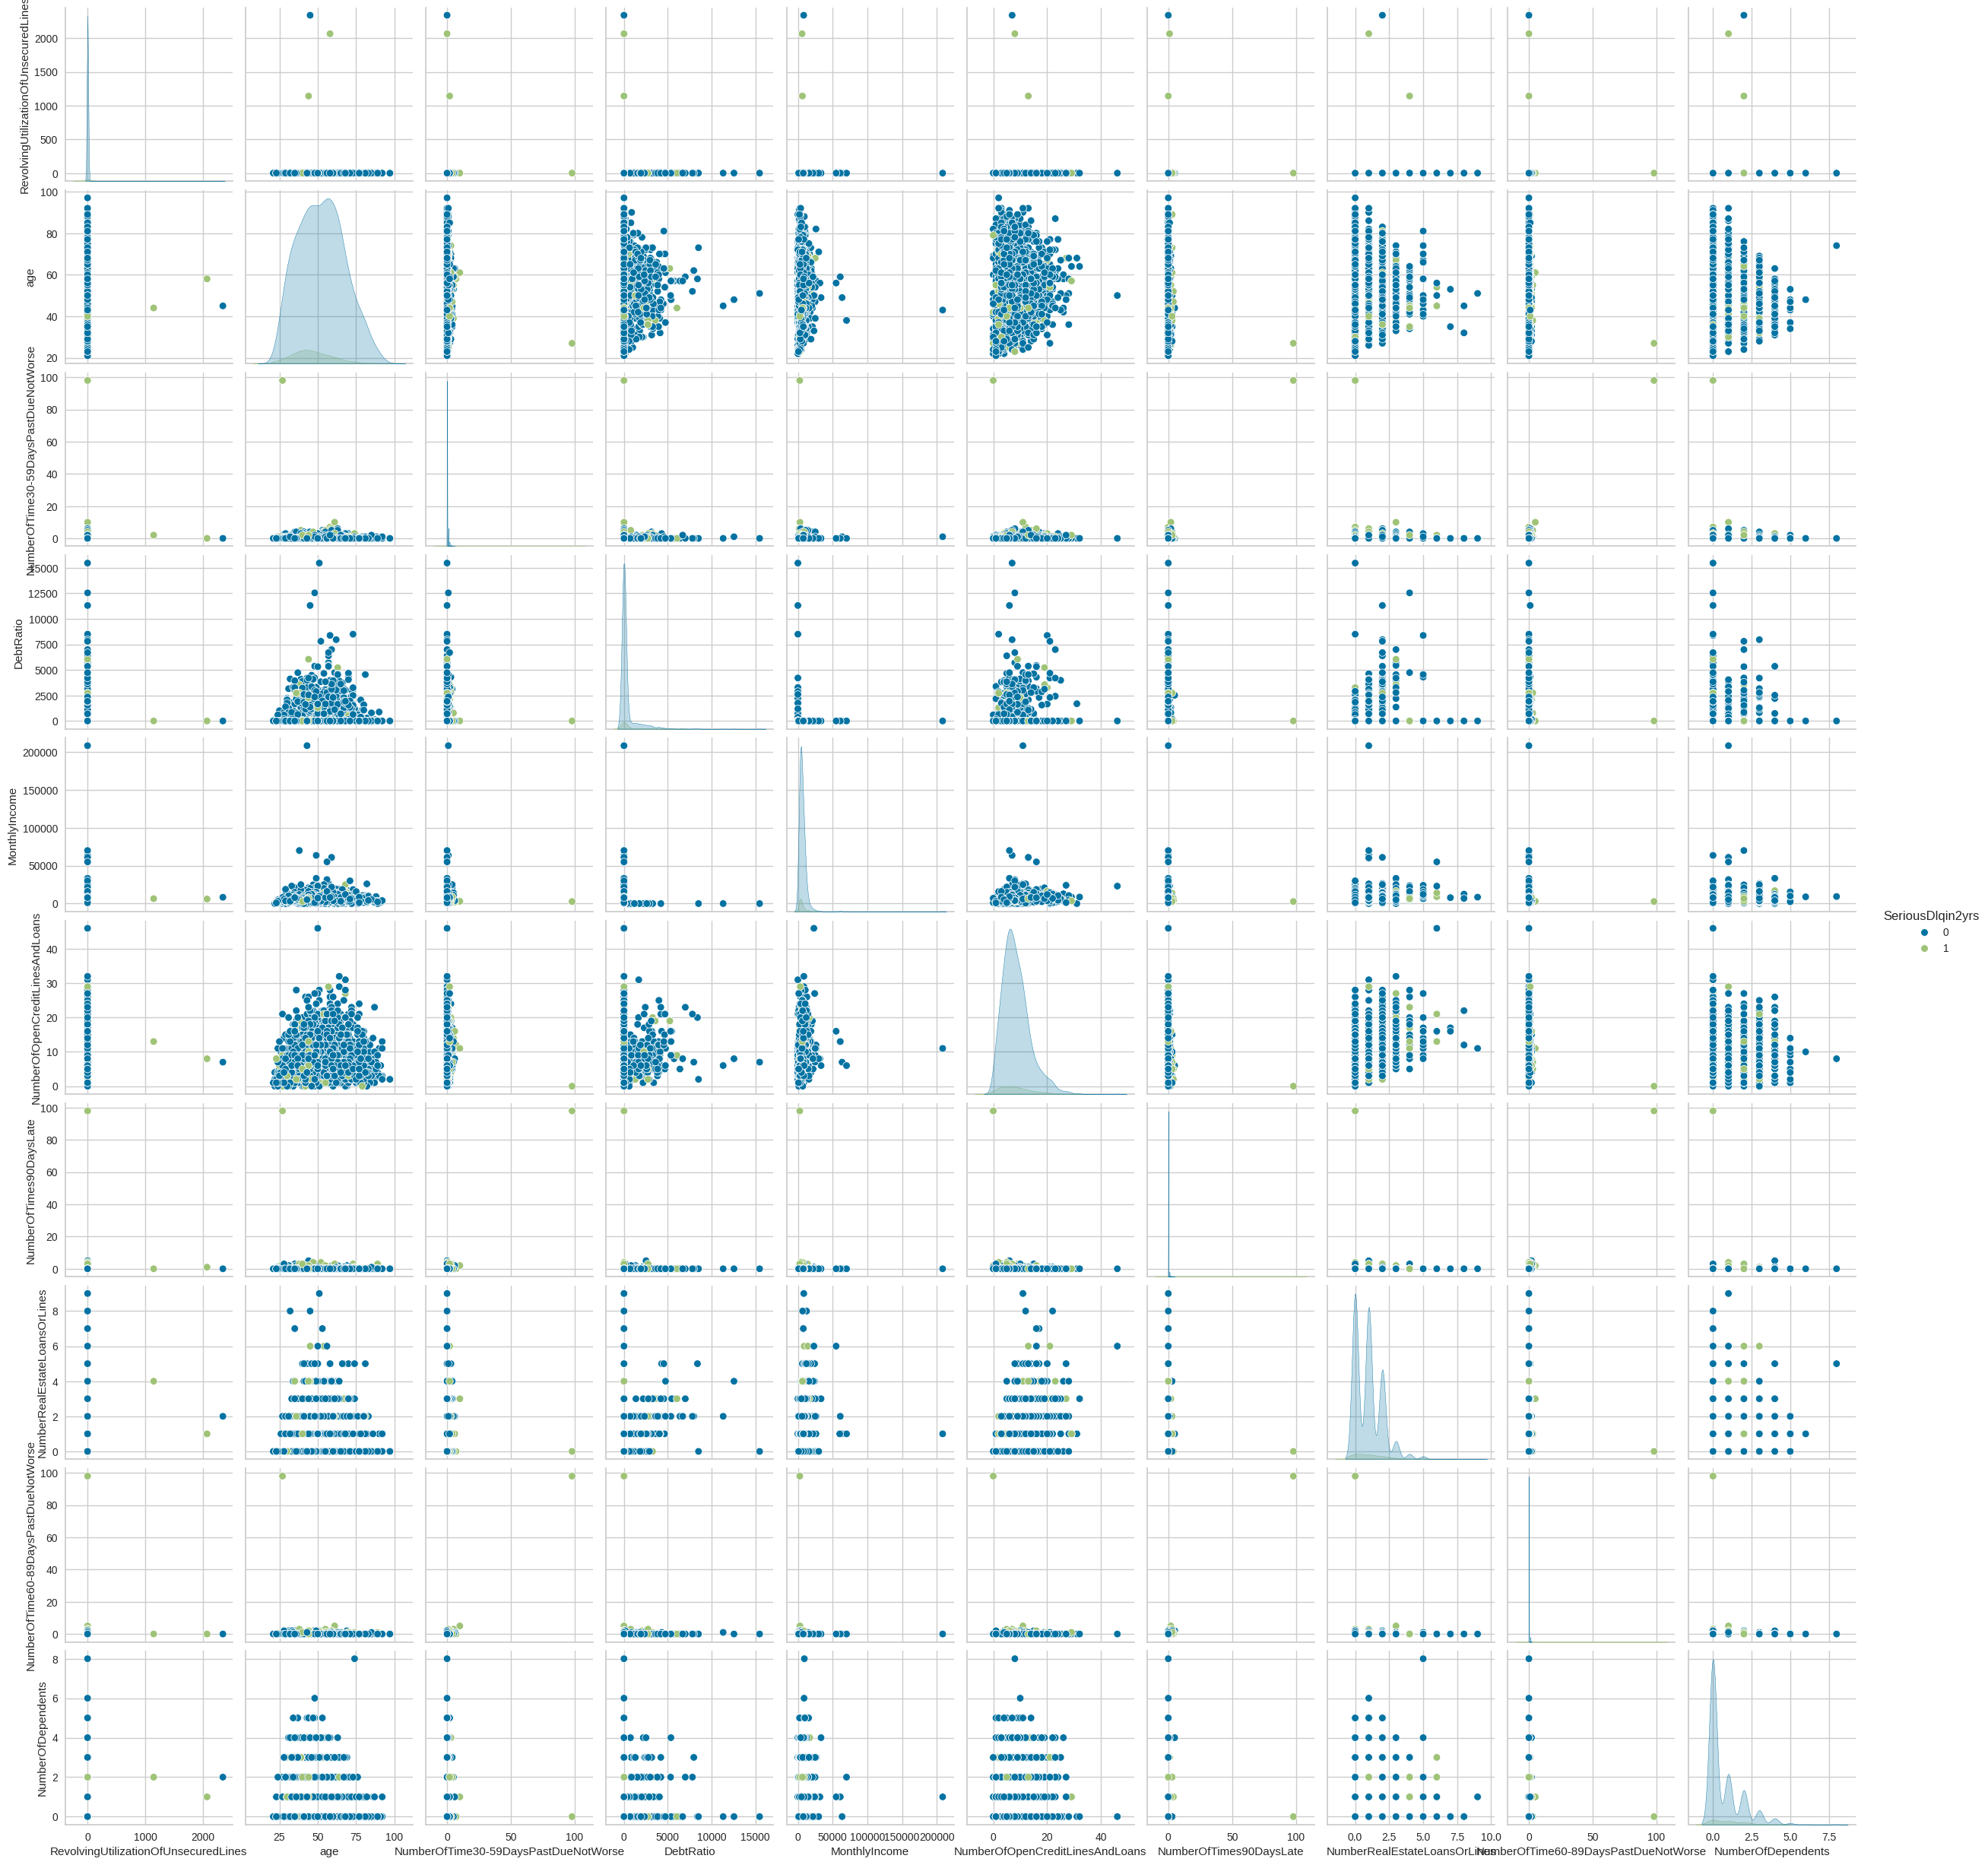

In [258]:
sns.pairplot(data.iloc[0:2000,:], hue= 'SeriousDlqin2yrs')

# Описательный анализ данных 

## Решение проблемы пропусков в наборе данных

Пропущенные значения (NaN) в данных возникают по разным причинам: ошибки при сборе данных, неответы в опросах, сбои оборудования и т.д. Наличие пропусков может сильно исказить выводы модели и статистику.

### Типы пропусков:
- **MCAR** (Missing Completely at Random): пропуски случайны, не зависят от других признаков.
- **MAR** (Missing At Random): пропуски зависят от других наблюдаемых признаков.
- **MNAR** (Missing Not At Random): пропуски зависят от самого пропущенного значения.

### Методы обработки:
1. **Удаление пропусков**
   - Полное удаление строк или столбцов с NaN.
   - Просто, но может сильно сократить выборку.

2. **Заполнение статистикой**
   - Среднее/медиана/мода по признаку.
   - Быстро, но не учитывает взаимосвязи между признаками.

3. **Импутация по соседним значениям**
   - Метод ближайших соседей (KNN imputation), линейная регрессия и т.п.
   - Более точная оценка, особенно при MAR.

4. **Модели машинного обучения**
   - Моделирование пропущенного признака как целевой переменной.


### Визуализация пропусков

Для визуализации используется библиотека missingno

<Axes: >

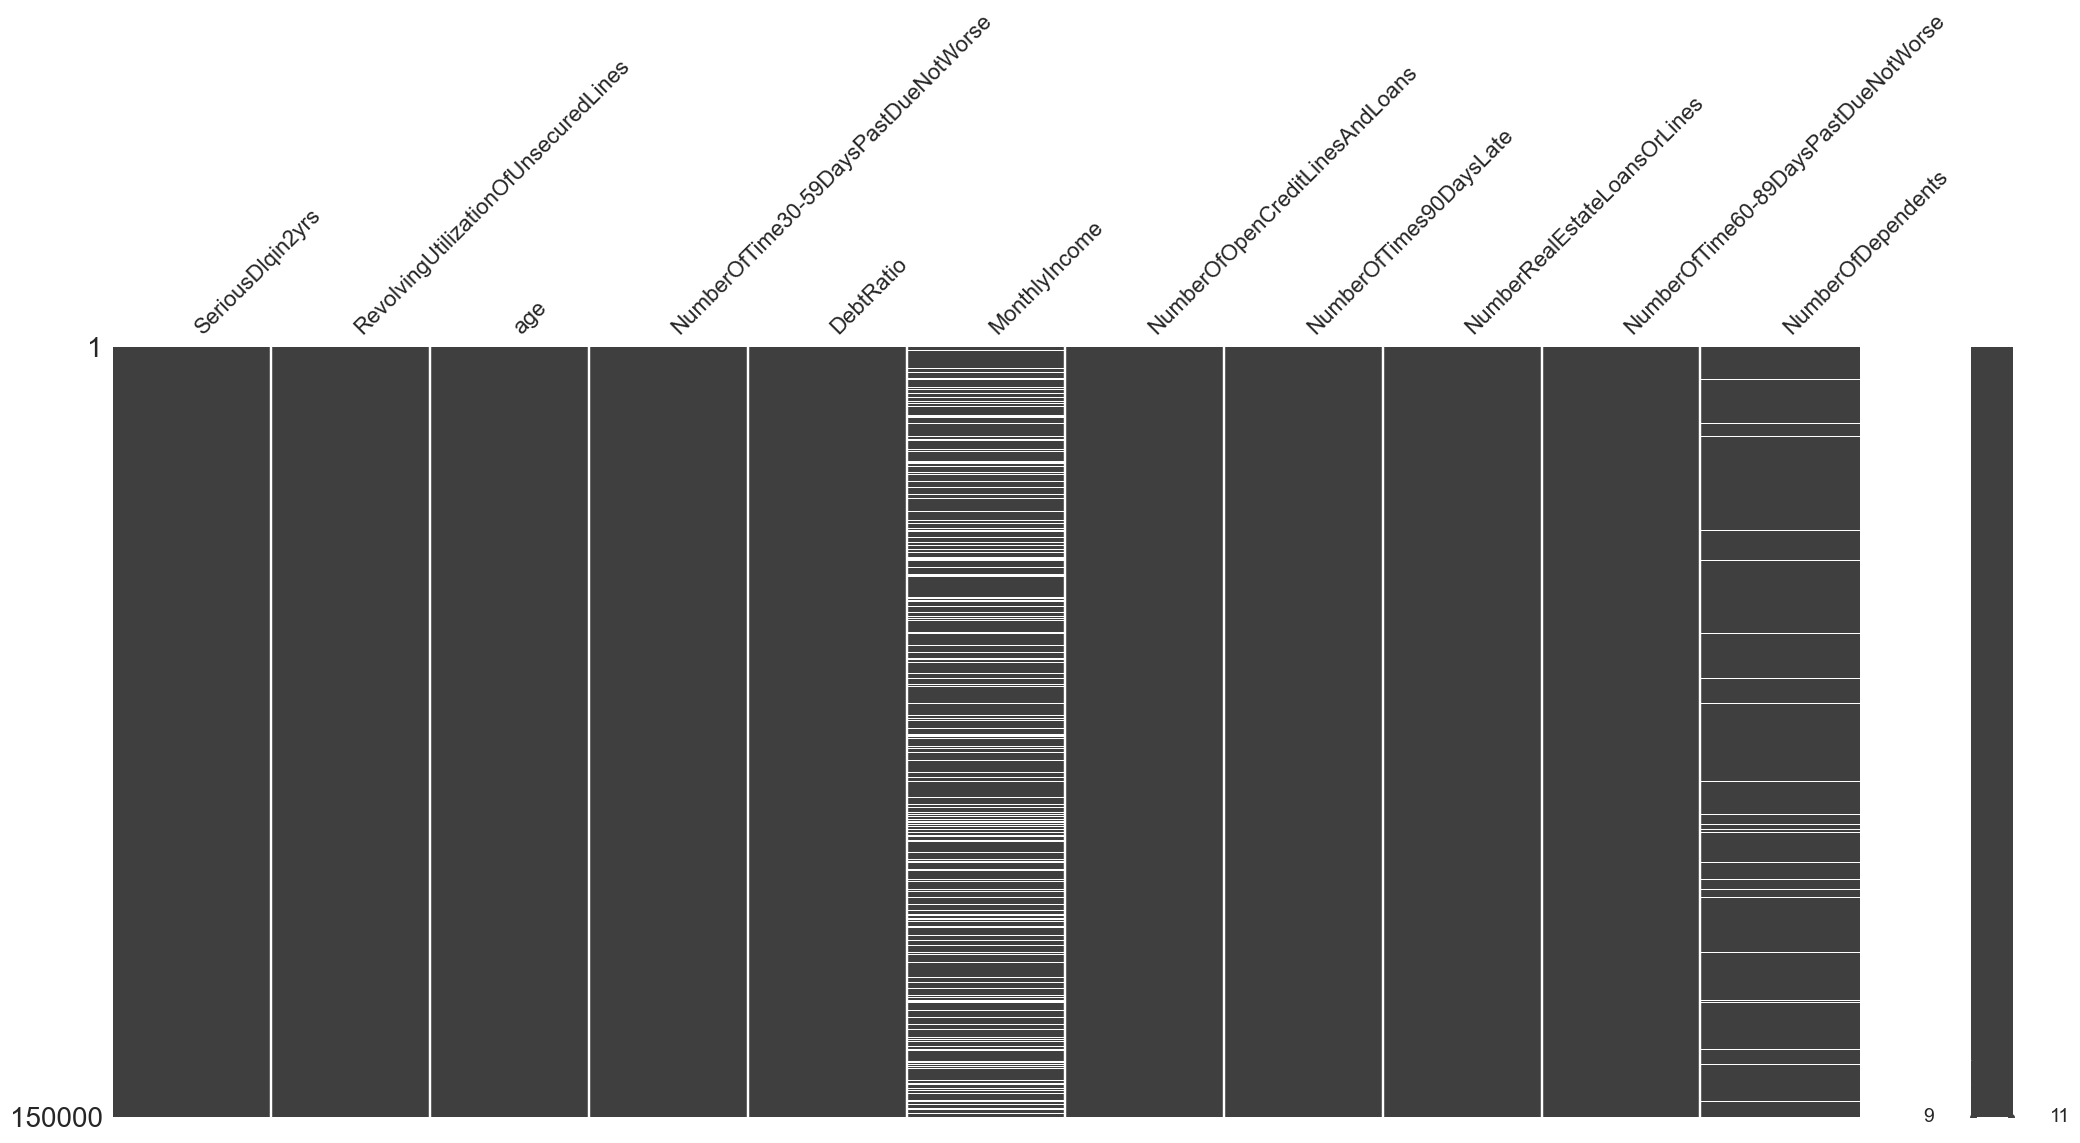

In [3]:
msno.matrix(data)

Как видно выше, пропуски имеются в признаках MonthlyIncome и NumberOfDependents. Объекты с пропусками не удаляются, так как будет потеряна не малая часть обучающей выборки. 

Поэтому пропущенные значения будут восстанавливаться:
- Для **MonthlyIncome**, пропуски в котором составляют примерно 19% от всех данных, будет построен регрессор на основе всеех остальных атрибутов.
- Для **NumberOfDependents**, пропуски в котором составляют примерно 2% от всех данных, значения будут восстановлены медианным значением.

### Восстановление данных в атрибуте NumberOfDependents

In [4]:
data["NumberOfDependents"] = data["NumberOfDependents"].fillna(data["NumberOfDependents"].median())

### Восстановление данных в атрибуте MonthlyIncome

In [5]:
train = data[data["MonthlyIncome"].isnull() == False]
test = data[data["MonthlyIncome"].isnull() == True]

X_train = train.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)
y_train = train["MonthlyIncome"]
X_test = test.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

lmMod = LinearRegression().fit(X_train, y_train)

pred = []
for _ in lmMod.predict(X_test):
    if _ > 0:
        pred.append(_)
    else:
        # Если зарплатала отлична от 0, то заменяю медианным значением
        pred.append(y_train.median())

j = 0
for i in test.index:
    data.loc[i, "MonthlyIncome"] = pred[j] 
    j += 1

<Axes: >

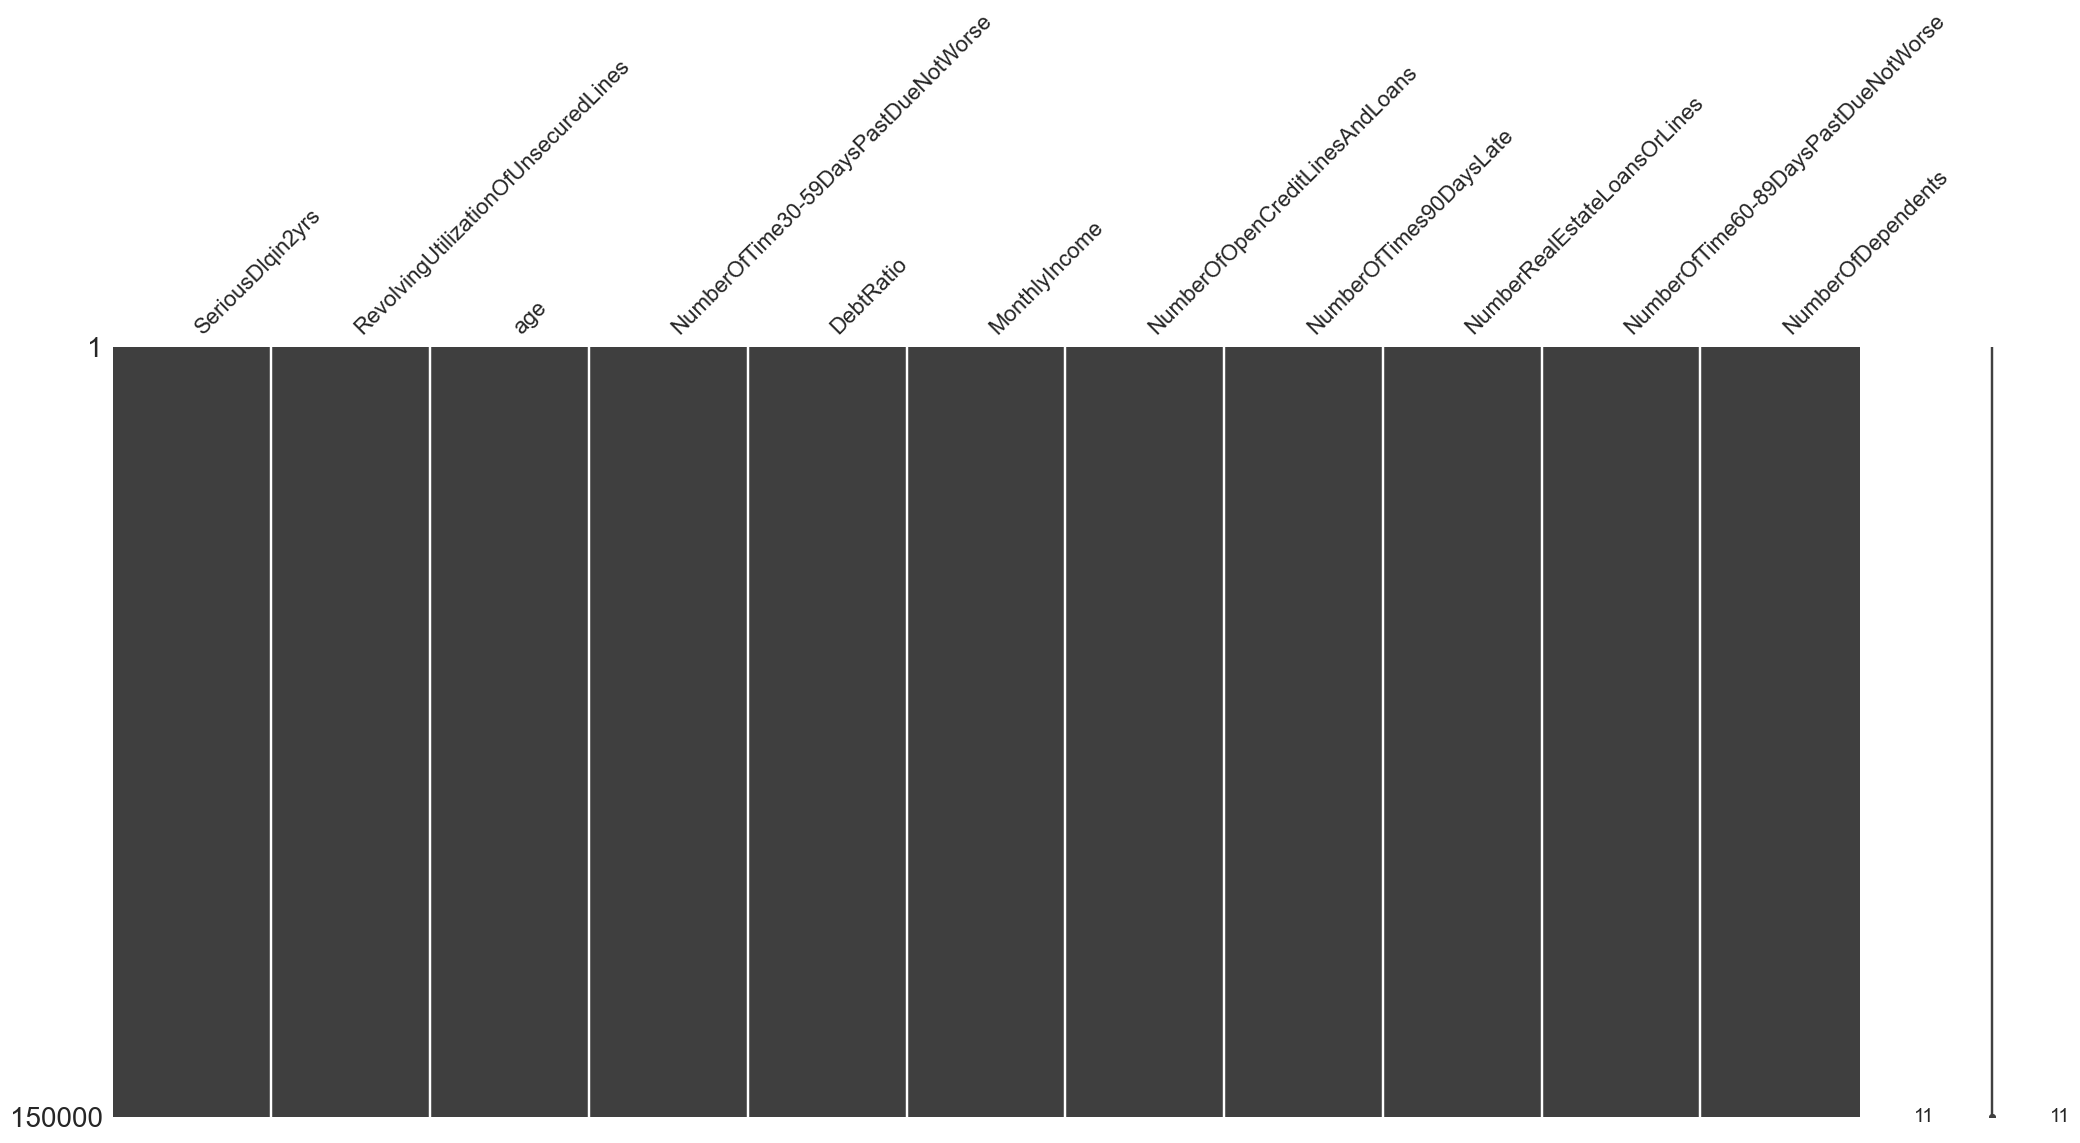

In [6]:
msno.matrix(data)

## Поиск и удаление выбросов

**Выбросы** — это необычные значения, значительно отличающиеся от остальных. Они могут быть следствием ошибок измерения, ошибок в данных или быть настоящими, но крайне редкими случаями.

### Методы выявления:
1. **Статистические методы**
   - Z-score: точки с отклонением > 3 считаются выбросами.
   - IQR (межквартильный размах): значения за границами [Q1 - 1.5×IQR, Q3 + 1.5×IQR].

2. **Машинное обучение**
   - One-Class SVM, Isolation Forest, Local Outlier Factor (LOF) — строят модель "нормальности" и ищут отклонения.

3. **Визуализация**
   - boxplot, scatter-plot, диаграммы распределения.

### Обработка:
- Удаление выбросов.
- Замена на усреднённые значения.
- Логарифмирование или другие преобразования (если выбросы не аномальные, а просто сильно смещены).


### Визуализация выбросов с помощью boxplot

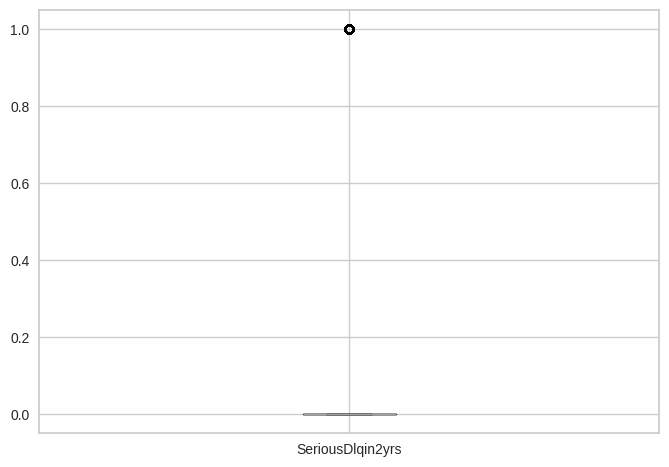

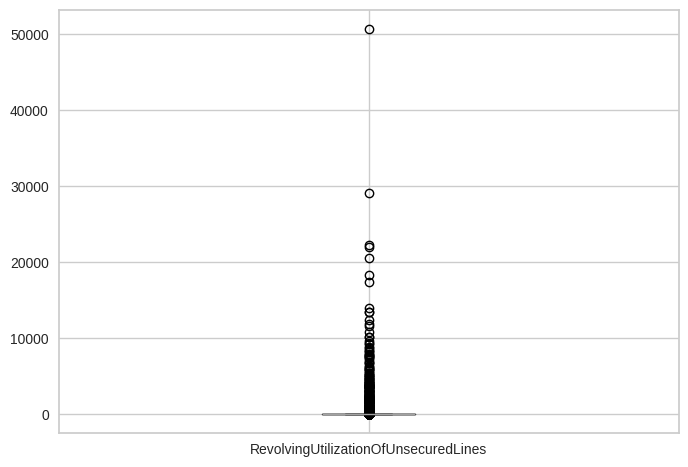

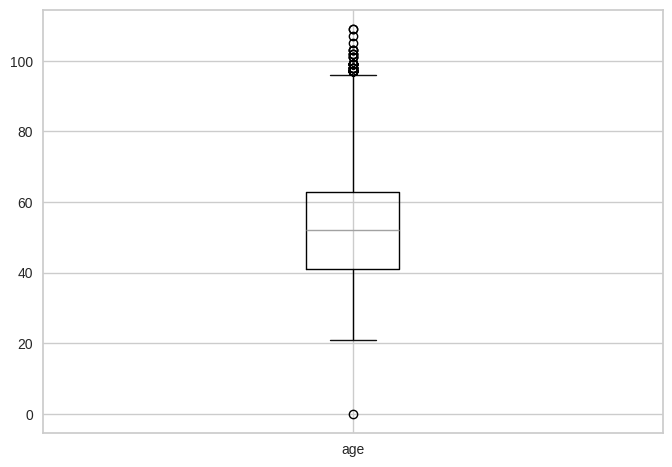

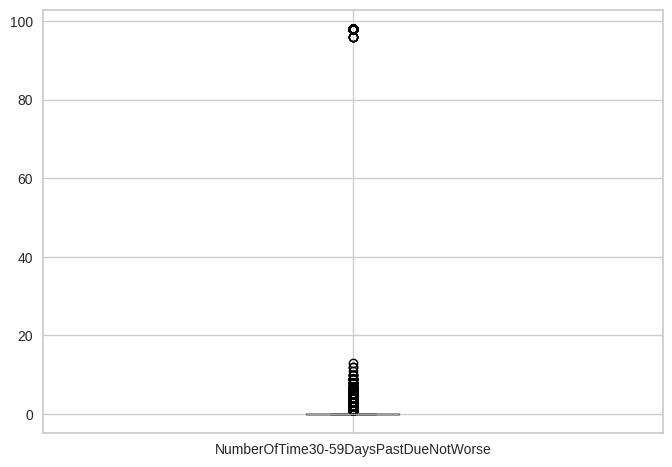

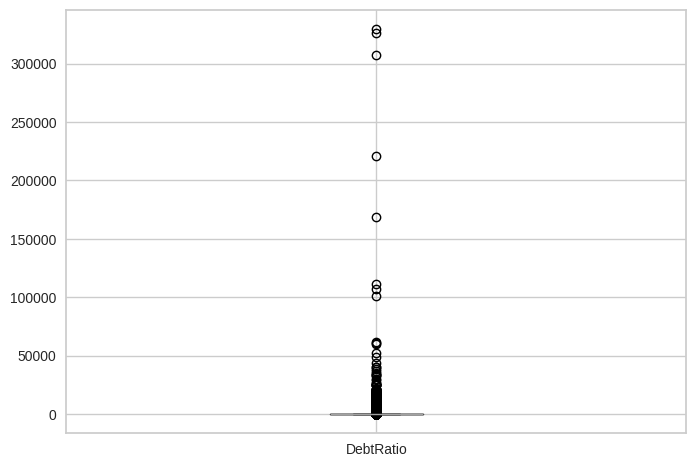

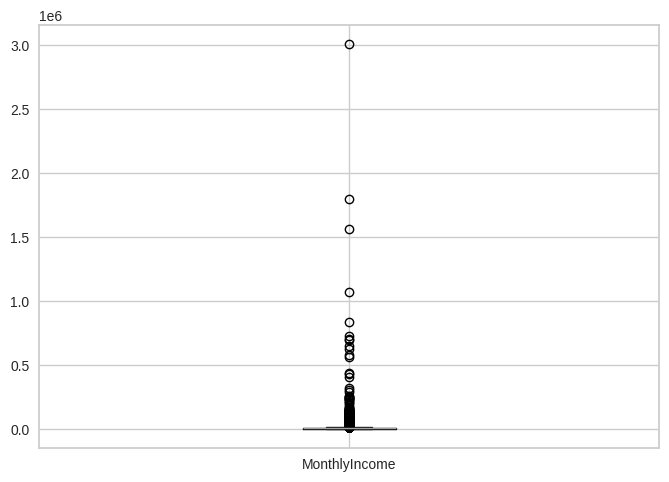

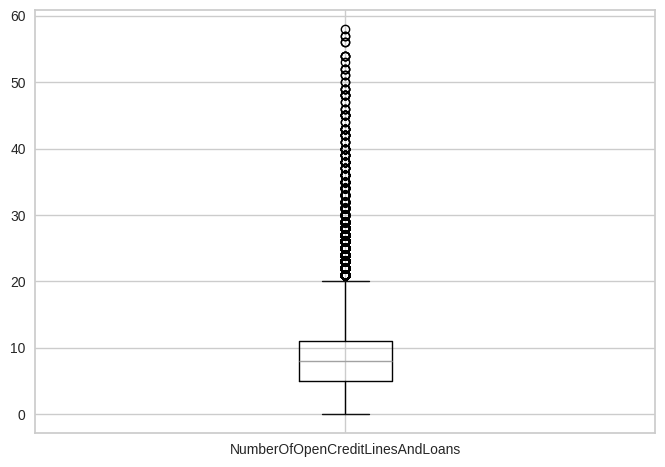

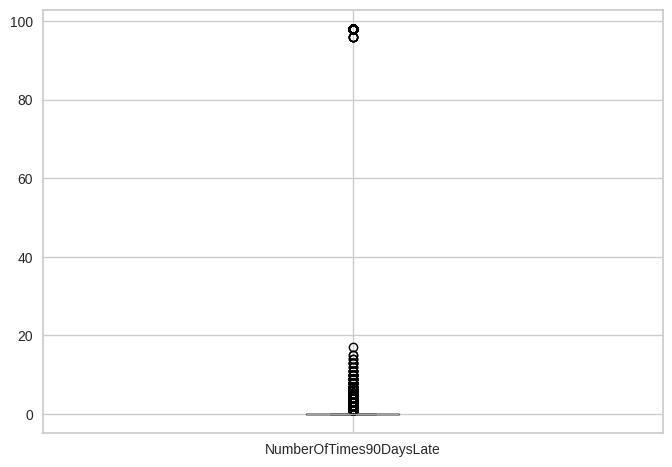

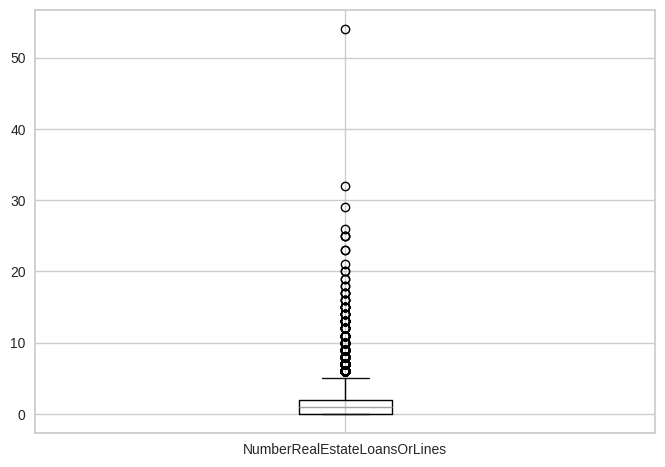

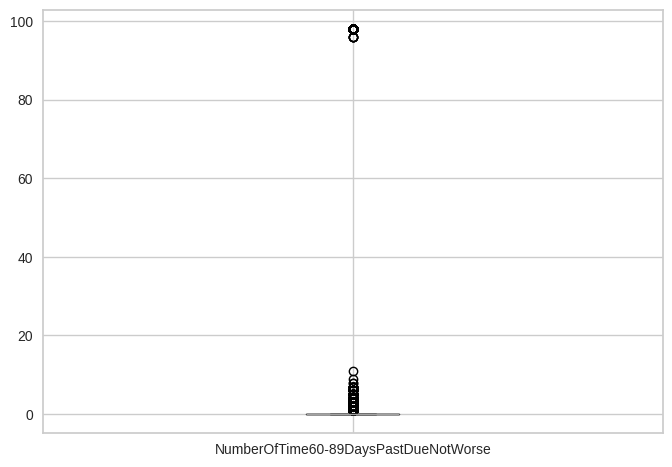

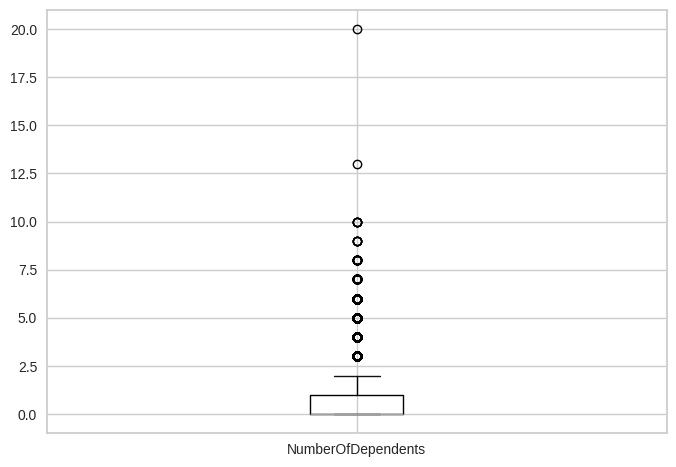

In [263]:
for col in data.columns:
    plt.subplots(1, 1)
    pd.DataFrame(data[col]).boxplot()
    plt.show()

Сначала будут удалены те объекты чьё значение "age" превыщает полтора квартильного размаха или которое меньше 22 лет. Нижняя допустимая граница возраста выбрана из предположения, что, в среднем, человек начинает зарабатывать деньги и, следоватльно, имеет возможность взять кредит, с 22 лет.

Другие заменяю на медиану. Кроме NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, так как, в основном, они равны нулю и выбросы в этих признаках несут важную инфорацию. 

In [7]:
topline = data["age"].quantile(0.75) + (data["age"].quantile(0.75) - data["age"].quantile(0.25)) * 1.5 
downline = 22
data = data.drop(data["age"][data["age"] > topline].index)
data = data.drop(data["age"][data["age"] < downline].index)

In [8]:
another_columns = set(data.columns) - set(["age", "SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"])
for column in another_columns:
    Q1, Q3 = data[column].quantile(0.25), data[column].quantile(0.75)
    IRQ = Q3 - Q1 
    topline = Q3 + IRQ * 1.5 
    downline = Q1 - IRQ * 1.5 
    median = data[column].interpolate()
    data.loc[data[data[column] > topline].index, column] = median
    data.loc[data[data[column] < downline].index, column] = median

## Визуализация распределения

Из-за огромного количества данных построить распределения для каждого атрибута по всем данным слишком затратно по времени. Поэтому использую train_test_split из sklearn для создания репрезентативной подвыборки. Обратим внимание на дизбаланс классов в таргете, а именнно на графике "SeriousDlqin2yrs".

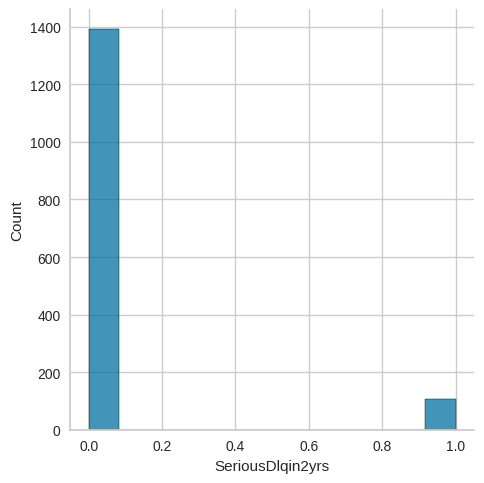

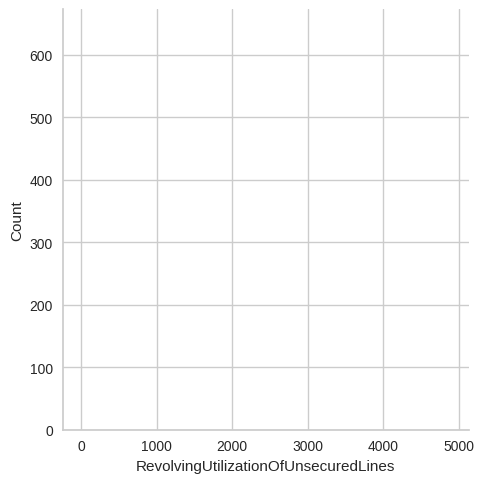

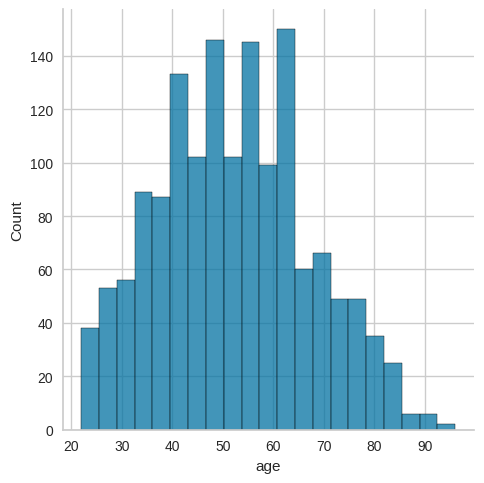

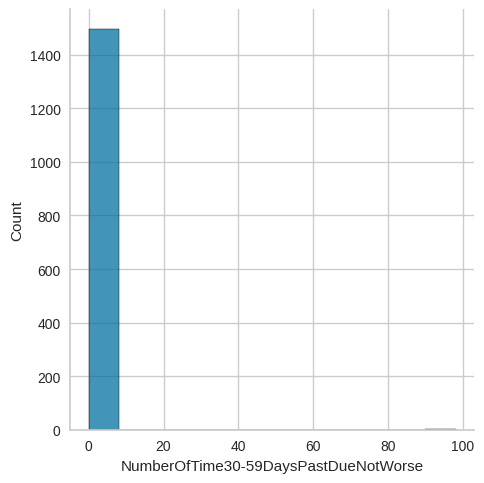

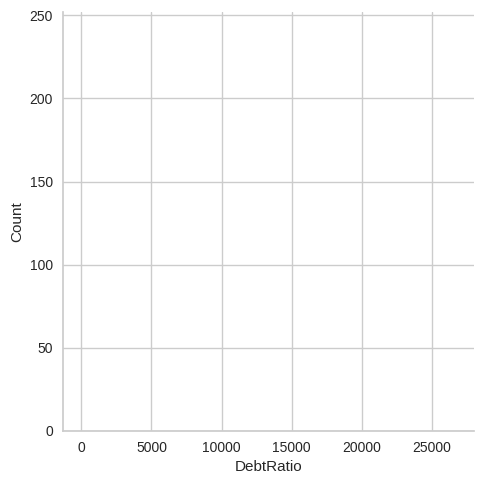

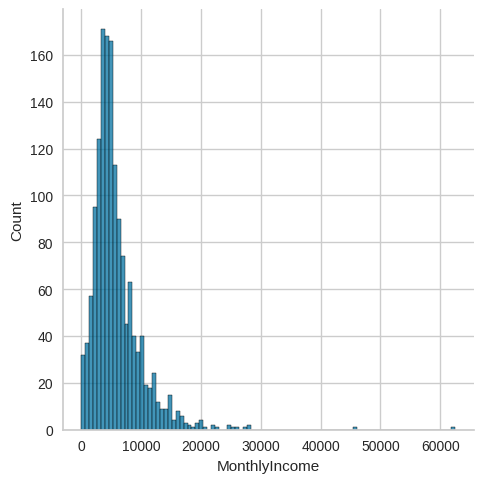

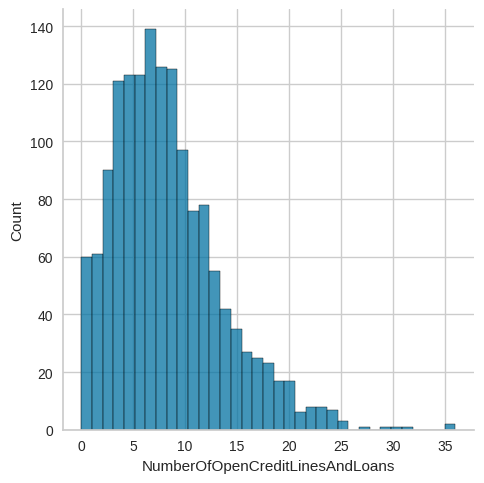

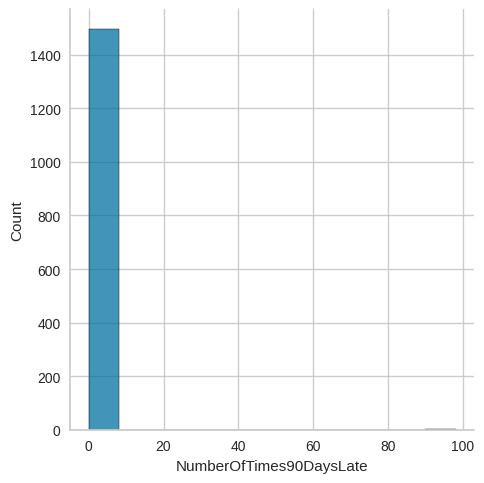

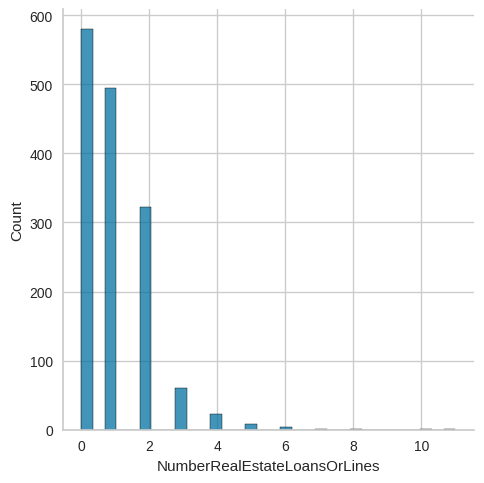

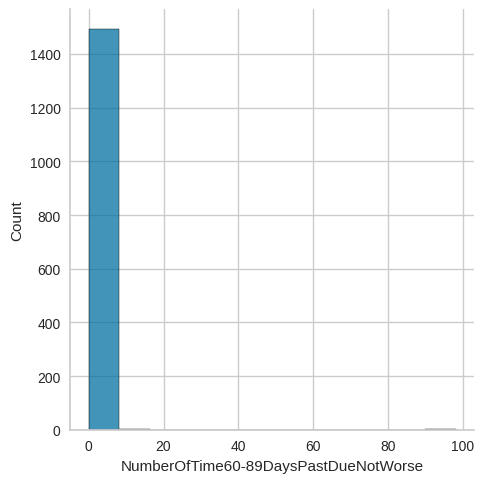

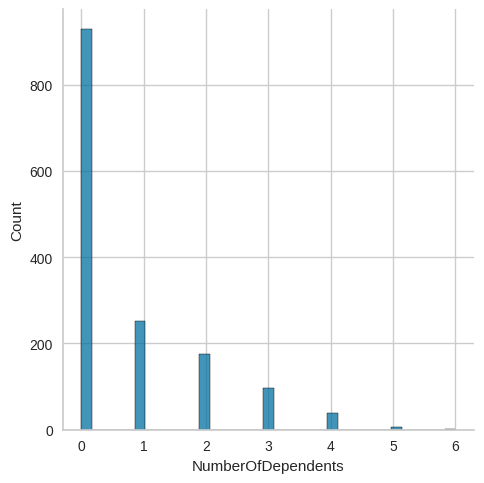

In [266]:
for column in data.columns:
    data_col, _ = train_test_split(data[column], test_size=0.01)
    display(sns.displot(_))

Как видно, не сбалансированы признаки:
- NumberOfTime30-59DaysPastDueNotWorse
- NumberOfTimes90DaysLate
- NumberOfTime60-89DaysPastDueNotWorse

Принято решение провести бинаризацию этих признаков. Данное решение принято на основании того, что при оценке клиента на предмет возврата кредита, не столь важно сколько раз он задерживал возврат прошлых кредитов на 90 и более дней, важен сам факт. 

In [ ]:
scaler = Binarizer(threshold=0)  # Пороговое значение для бинаризации
data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"] = scaler.fit_transform(data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"])
data.loc[:, "NumberOfTimes90DaysLate"] = scaler.fit_transform(data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"])
data.loc[:, "NumberOfTime60-89DaysPastDueNotWorse"] = scaler.fit_transform(data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"])

## Корреляционная матрица

In [267]:
def draw_cov(data):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix')
    sns.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

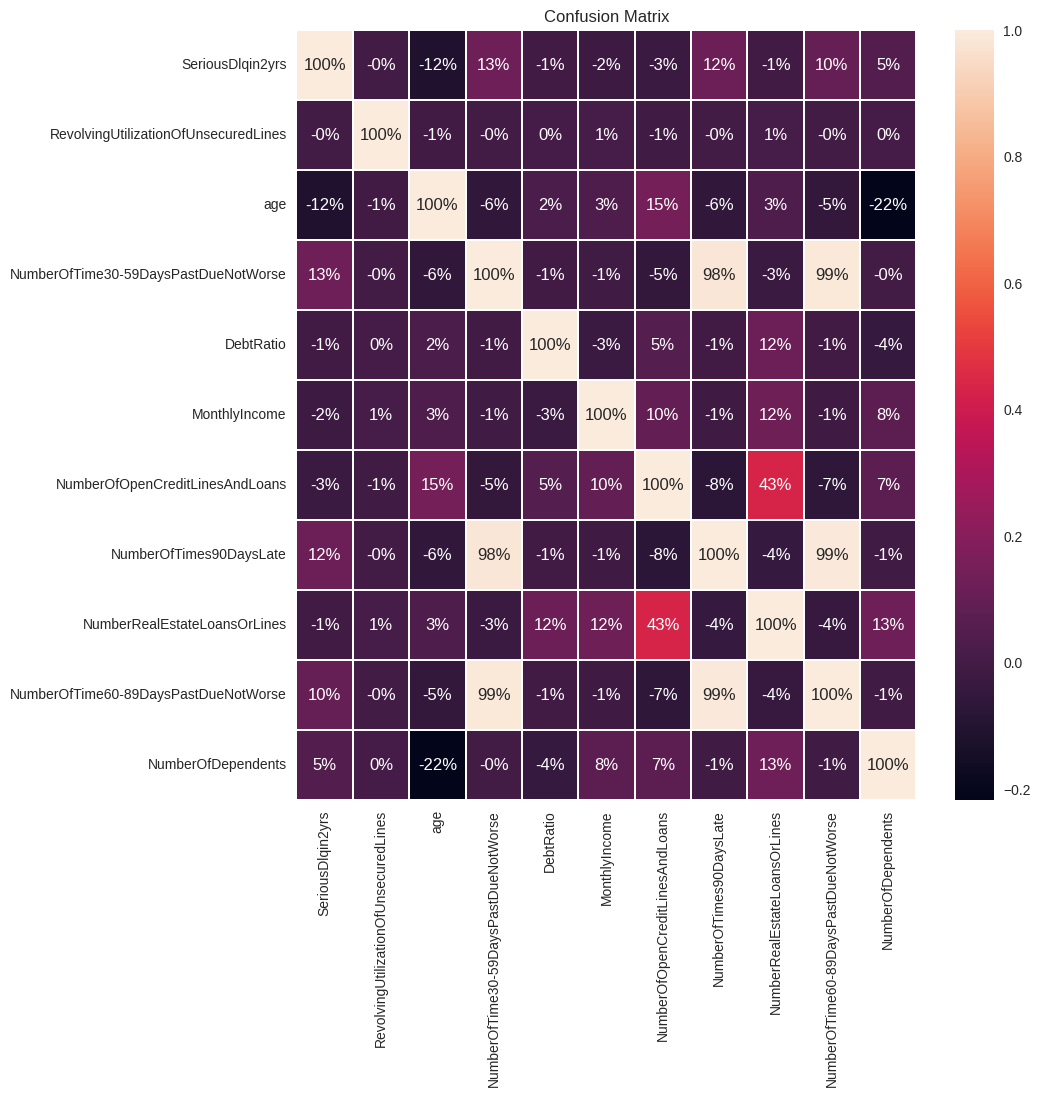

In [268]:
draw_cov(data)

# Выявление наиболее информативных признаков

Не все признаки одинаково важны. Некоторые из них шумовые, другие — избыточные. Удаление неинформативных признаков:
- Ускоряет обучение
- Повышает обобщающую способность модели
- Уменьшает переобучение

### Методы выбора признаков:
1. **Фильтрационные методы (Filter)**
   - Основаны на статистических метриках: дисперсия, корреляция, $\chi^2$, mutual information.
   - Быстрые, не зависят от модели.

2. **Обёрточные методы (Wrapper)**
   - Перебор подмножеств признаков с использованием модели.
   - Пример: RFE (Recursive Feature Elimination).

3. **Методы встроенного отбора (Embedded)**
   - Отбор встроен в обучение модели.
   - Пример: регуляризация Lasso (L1), дерево решений, Random Forest importance.

Эта часть анализа выполнена с помощью Random Forest importance - обученный на всей выборке, модель случайного леса покажет информативность и вариативность каждого отдельного атрибута. 

In [9]:
X, y = data[data.columns[1:]], data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

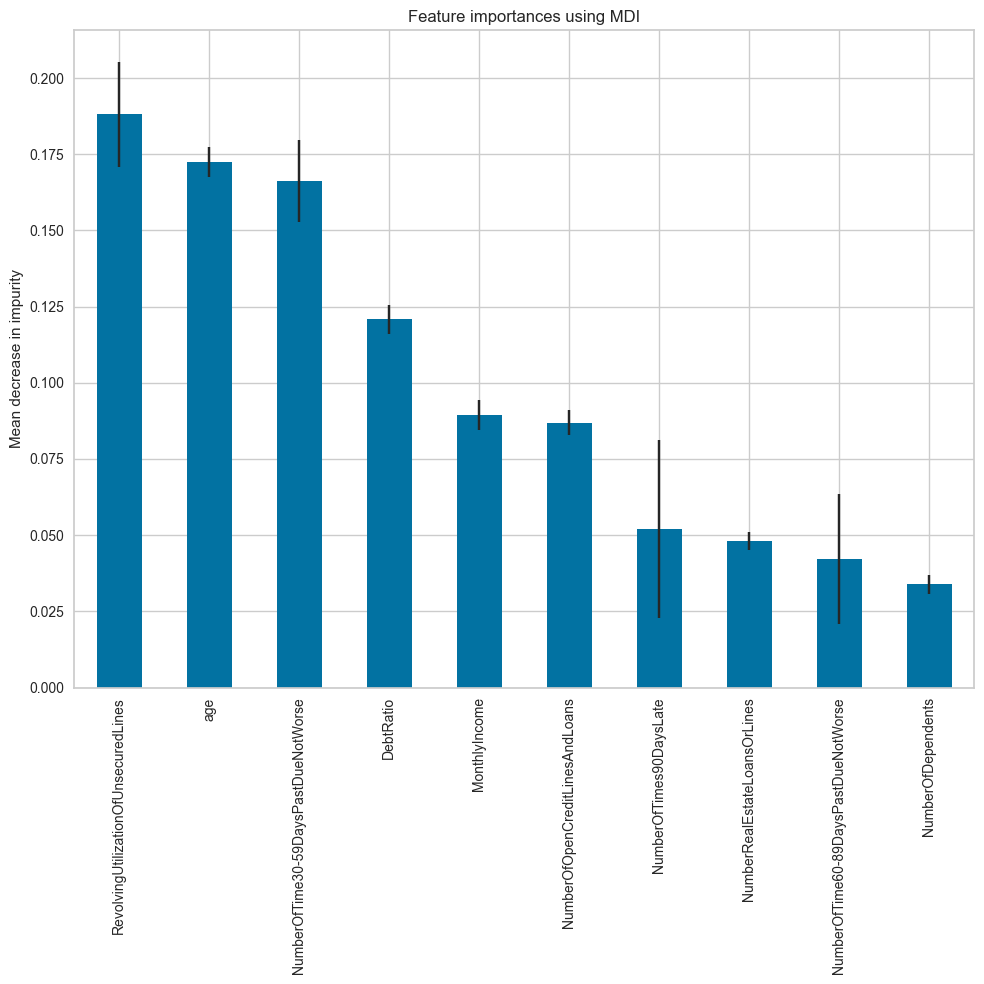

In [10]:
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(np.arange(0, 10, 1), labels=X.columns.tolist())
fig.tight_layout()

Анализ атрибутов с помощью случайного леса показал, что наиболее информативными признаками являются:
- RevolvingUtilizationOfUnsecuredLines
- age
- NumberOfTime30-59DaysPastDueNotWorse
- DebtRatio
- MonthlyIncome
- NumberOfOpenCreditLinesAndLoans

> Надо докинуть синтетических данных до того, как применять к ним PCA

## PCA

PCA — метод понижения размерности, позволяющий представить данные в новом пространстве меньшей размерности с сохранением максимально возможной доли дисперсии.

### Идея:
- Найти новые ортогональные оси (главные компоненты), по которым разброс данных максимален.
- Компоненты упорядочены по убыванию объяснённой дисперсии.

### Этапы:
1. Центрирование данных (вычитание среднего).
2. Вычисление ковариационной матрицы.
3. Нахождение собственных векторов и собственных значений.
4. Выбор k главных компонент и проекция данных.

### Применения:
- Визуализация данных в 2D/3D.
- Удаление шумов.
- Снижение размерности перед обучением модели.

Теперь применим PCA к выявленным ранее наиболее информативным признакам, возможно получиться понизить размерность с сохранением большей дисперсии данных. Заодно избавимся от возможного шума.

In [17]:
X_random_forest = X.loc[:,["RevolvingUtilizationOfUnsecuredLines", 
                           "age", 
                           "NumberOfTime30-59DaysPastDueNotWorse", 
                           "DebtRatio", 
                           "MonthlyIncome",
                           "NumberOfOpenCreditLinesAndLoans"]]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_random_forest)

pca_machine = PCA(n_components=min(X_random_forest.shape[0], X_random_forest.shape[1]), svd_solver="covariance_eigh")

pca_X = pca_machine.fit(pd.DataFrame(scaled_X, columns=X_random_forest.columns.values))

pca_importances = pd.Series(pca_X.explained_variance_ratio_, index=pca_X.get_feature_names_out())

Общая объясненная дисперсия 0.9999999999999999


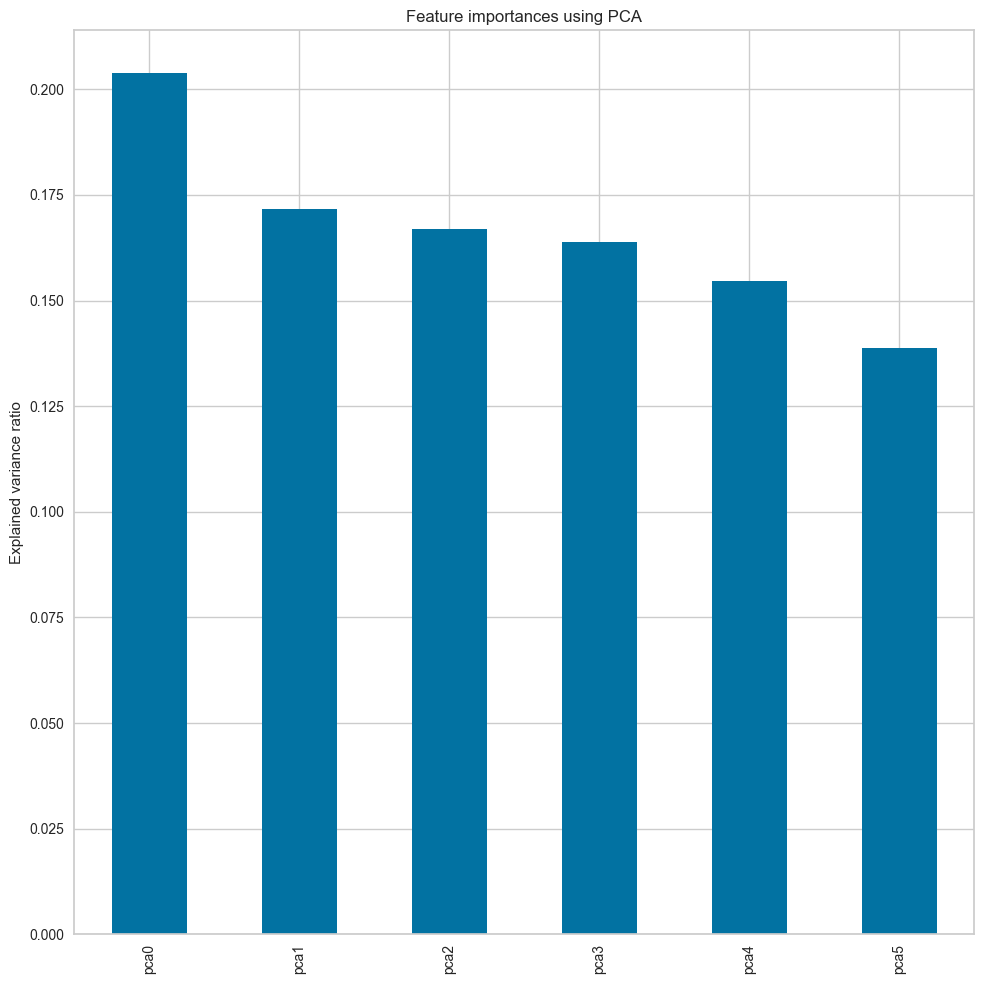

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
pca_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using PCA")
ax.set_ylabel("Explained variance ratio")
ax.set_xticks(np.arange(0, X_random_forest.shape[1], 1), labels=pca_X.get_feature_names_out())
fig.tight_layout()

most_explainde_pca_X = pca_X.explained_variance_ratio_[:6]
print(f"Общая объясненная дисперсия {most_explainde_pca_X.sum()}")

transformed_X = pca_machine.transform(pd.DataFrame(scaled_X, columns=X_random_forest.columns.values))

# Разделение данных на тестовую и обучающую выборки

Из-за огромного количества данных для теста достаточно 0.01 от всего массива данных

In [ ]:
X, y = transformed_X, data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)  

# Борьба с дизбалансом классов

Когда один класс значительно доминирует над другими, большинство алгоритмов классификации склонны игнорировать малочисленные классы. Это приводит к высокой accuracy, но плохому качеству по другим метрикам.

### Методы борьбы:

1. **Ресемплирование**
   - Oversampling (например, SMOTE): увеличивает число объектов меньшинства.
   - Undersampling: уменьшает количество объектов большинства.
   - Комбинированные методы: SMOTE + Tomek links.

2. **Изменение метрик**
   - Использование F1-score, ROC-AUC, Precision-Recall вместо accuracy.

3. **Взвешивание классов**
   - Передача весов классов в модель (например, class_weight="balanced" в sklearn).

4. **Генерация синтетических примеров**
   - SMOTE, ADASYN: генерируют искусственные точки для миноритарного класса.


Из-за дизбаланса классов решено добавить синтетических данных с использлованием **ADASYN** для балансировки классов.


# ADASYN

**ADASYN** — это алгоритм генерации синтетических примеров для миноритарного класса, являющийся развитием метода **SMOTE**. Главное отличие: ADASYN создаёт больше новых примеров **в тех зонах пространства, где миноритарный класс плохо представлен**, т.е. адаптивно усиливает сложные области.

### Алгоритм ADASYN:

1. Для каждого примера миноритарного класса оценивается его "сложность":
   - Считается, сколько соседей среди ближайших K — это объекты из другого класса.
   - Чем больше таких соседей, тем сложнее точка, и тем больше ей нужно "усиления".

2. Вычисляется общее количество новых примеров, которые нужно сгенерировать.

3. Новые точки создаются как линейные комбинации исходной точки и её ближайших соседей (как в SMOTE), но количество сэмплов на каждую точку определяется её "сложностью".

### Преимущества:
- ADASYN не просто выравнивает классы, а **умно перераспределяет внимание** к сложным регионам.
- Может улучшить качество классификации, особенно если дисбаланс неравномерно выражен.

### Недостатки:
- При сильной зашумленности данных может усиливать шум.
- Как и любой oversampling, может увеличить время обучения модели.

In [212]:
from imblearn.over_sampling import ADASYN

# Создание экземпляра ADASYN
adasyn = ADASYN()

# Применение ADASYN к данным
X_train, y_train = adasyn.fit_resample(X_train, y_train)

# Подбор моделей

Далее представлены базовые модели и сравнительная табилца по основным метрикам, таким как:
- accuracy
- precision
- recall
- f1
- train_time

In [213]:
models_info = {"model": [], 
               "accuracy": [],
               "precision": [],
               "recall": [],
               "f1": [],
               "train_time": []}

def add_new_row(model, train_time, X_test, y_true):
    y_pred = model.predict(X_test)
    models_info["model"].append(type(model).__name__)
    models_info["accuracy"].append(accuracy_score(y_true, y_pred))
    models_info["precision"].append(precision_score(y_true, y_pred))
    models_info["recall"].append(recall_score(y_true, y_pred))
    models_info["f1"].append(f1_score(y_true, y_pred))
    models_info["train_time"].append(train_time)

## DecisionTreeClassifier

In [214]:
%time
model_DT = DecisionTreeClassifier().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [215]:
add_new_row(model_DT, 1.1, X_test, y_test)

print(f"ROC_AUC: {roc_auc_score(y_test, model_DT.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_DT, X, y, scoring="roc_auc"))}")

ROC_AUC: 0.6042493953554012
 Cross validation score: 0.5639480333214921


## GaussianNB

In [216]:
%time
model_GNB = GaussianNB().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [217]:
add_new_row(model_GNB, 0.3, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_GNB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GNB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5677264700074021
 Cross validation score: 0.6600960293315628


## LogisticRegression

In [218]:
%time
model_LogReg = LogisticRegression().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [219]:
add_new_row(model_LogReg, 3.3, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_LogReg.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.6763379019696709
 Cross validation score: 0.6633738640481173


## Random Forest

In [220]:
%time
model_RF = RandomForestClassifier().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [221]:
add_new_row(model_RF, 26.2, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_RF.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_RF, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.6278884299888566
 Cross validation score: 0.7306625387459544


## Gradient Boosting

In [222]:
%time
model_GB = GradientBoostingClassifier().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [223]:
add_new_row(model_GB, 22.2 ,X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_GB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.6965349495707225
 Cross validation score: 0.7682192630278314


## KNN

In [224]:
%time
model_KNN = KNeighborsClassifier().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [225]:
add_new_row(model_KNN, 0 ,X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_KNN.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_KNN, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.6272328754278214
 Cross validation score: 0.6524876037807047


## Neural Network

In [226]:
%time
model_MLP = MLPClassifier().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [227]:
add_new_row(model_MLP, 11, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_MLP.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_MLP, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.7460474926014802
 Cross validation score: 0.7820430899023927


## AdaBoosting

In [228]:
%time
model_Ada = AdaBoostClassifier().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [229]:
add_new_row(model_Ada, 4.7, X_test, y_test)


print(f" ROC_AUC: {roc_auc_score(y_test, model_Ada.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_Ada, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.6885645805895231
 Cross validation score: 0.7565641199552703


Посмотрим на получившуюся таблицу с моделями и их эффективностью.

Из неё видно, что три лучших модели это:
- **AdaBoostClassifier**
- **GradientBoostingClassifier**
- **RandomForestClassifier**

In [230]:
pd.DataFrame(models_info)

,model,accuracy,precision,recall,f1,train_time
0,DecisionTreeClassifier,0.803702,0.141494,0.373475,0.205234,1.1
1,GaussianNB,0.290041,0.079097,0.889020,0.145269,0.3
2,LogisticRegression,0.680955,0.133047,0.670996,0.222063,3.3
3,RandomForestClassifier,0.832465,0.173776,0.391185,0.240649,26.2
4,GradientBoostingClassifier,0.702962,0.144914,0.689099,0.239469,22.2
5,KNeighborsClassifier,0.783965,0.144996,0.445887,0.218831,0.0
6,MLPClassifier,0.675881,0.152330,0.827233,0.257283,11.0
7,AdaBoostClassifier,0.703069,0.142357,0.671783,0.234930,4.7


# Подбор гиперпараметров

В большинстве моделей машинного обучения есть гиперпараметры — значения, которые нельзя напрямую обучить на данных (в отличие от параметров модели). Примеры: глубина дерева, коэффициент регуляризации, learning rate и т.д.

### Почему важно их подбирать?

- Хороший подбор гиперпараметров значительно улучшает качество модели.
- Плохие настройки могут привести к переобучению или недообучению.

### Подходы к подбору:

1. **Grid Search**
   - Перебирает все возможные комбинации из заданной сетки.
   - Простой, но крайне неэффективный в высоких размерностях.

2. **Random Search**
   - Случайный перебор гиперпараметров в заданных диапазонах.
   - Быстрее находит "достаточно хорошие" комбинации, особенно если только часть гиперпараметров важна.

3. **Байесовская оптимизация**
   - Использует вероятностную модель (обычно — Гауссовский процесс или дерево решений), чтобы аппроксимировать функцию качества.
   - На каждом шаге выбирает гиперпараметры, которые **максимизируют функцию приобретения** (expected improvement и т.д.).
   - Обеспечивает баланс **исследования** (exploration) и **эксплуатации** (exploitation).

Байесовская оптимизация **учится** на предыдущих итерациях, чтобы предсказывать, где может быть улучшение.

Но перед тем, как приступить к оптимизации нужно получить все численные параметры, так как реализованная в рамках курсовой работы байесовская оптимизация не приспособлена к работе с категориальными данными!

Качество модели в оптимизации оценивется с помощью метрики precision.

In [113]:
def get_model_numeric_params(model):
    for key, value in model.get_params().items():
        if not isinstance(value, str) and not isinstance(value, type(None)):
            print(f"{key} {type(value)}")

def get_scores(model, X_test, y_true):
    y_pred = model.predict(X_test)
    print(f"accuracy_score: {accuracy_score(y_true, y_pred)}")
    print(f"precision_score: {precision_score(y_true, y_pred)}")
    print(f"recall_score: {recall_score(y_true, y_pred)}")
    print(f"f1_score: {f1_score(y_true, y_pred)}")

def get_cross_val_scores(model, X, y):
    print(f"accuracy_score: {np.mean(cross_val_score(model, X, y, scoring="accuracy"))}")
    print(f"precision_score: {np.mean(cross_val_score(model, X, y, scoring="precision"))}")
    print(f"recall_score: {np.mean(cross_val_score(model, X, y, scoring="recall"))}")
    print(f"f1_score: {np.mean(cross_val_score(model, X, y, scoring="f1_macro"))}")

## Настройка гиперпараметров GradientBoostingClassifier с помощью байесовсокой оптимизации

In [233]:
get_model_numeric_params(GradientBoostingClassifier())

ccp_alpha <class 'float'>
learning_rate <class 'float'>
max_depth <class 'int'>
min_impurity_decrease <class 'float'>
min_samples_leaf <class 'int'>
min_samples_split <class 'int'>
min_weight_fraction_leaf <class 'float'>
n_estimators <class 'int'>
subsample <class 'float'>
tol <class 'float'>
validation_fraction <class 'float'>
verbose <class 'int'>
warm_start <class 'bool'>


In [236]:
from bayes_opt_class import BayesOptimization

params = {"learning_rate": (float, [0, 1]),
          "n_estimators": (int, [2, 10]),
          "max_depth": (int, [1, 10]),
          "min_samples_leaf": (int, [2, 10]),
          "min_samples_split": (int, [2, 10]),
          "tol": (float, [0, 1])}

score, params = BayesOptimization(GradientBoostingClassifier(), params, n_iters=5, scoring="precision").fit(X_train, y_train)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.7184720078816844
best params: {'learning_rate': 0.29795349765508117, 'n_estimators': 8.0, 'max_depth': 8.0, 'min_samples_leaf': 2.0, 'min_samples_split': 7.0, 'tol': 0.062260619591215205}


### Посмотрим на результат

In [ ]:
# все параметры возвращаются в формате float, но некоторые их них необходимо подавать в формате int  
for key, value in params.items():
    if int(value) - value == 0:
        params[key] = int(value)
params

{'learning_rate': 0.36143638044478854,
 'n_estimators': 3,
 'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'tol': 0.4306676626169038}

In [ ]:
%time
model_GB = GradientBoostingClassifier(**params).fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print("Scores:")
get_scores(model_GB, X_test, y_test)
print("Cross Validation Scores:")
get_cross_val_scores(model_GB, X, y)

Scores:
accuracy_score: 0.9361162300029378
precision_score: 0.5883748517200474
recall_score: 0.1951987406532861
f1_score: 0.29314420803782504
Cross Validation Scores:
accuracy_score: 0.9363962393257154
precision_score: 0.5824514858587828
recall_score: 0.17232767232767232
f1_score: 0.616185243893067


### Анализ модели

Ниже представлен график обучения модели

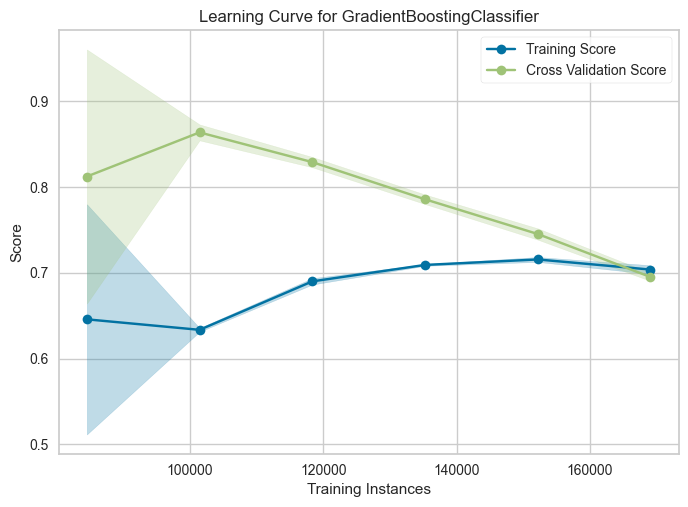

In [232]:
metric = make_scorer(precision_score, response_method="predict")
visualizer = LearningCurve(
    GradientBoostingClassifier(), scoring=metric, cv=StratifiedKFold(), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_train, y_train).show()

## Настройка гиперпараметров RandomForestClassifier с помощью байесовсокой оптимизации

In [120]:
get_model_numeric_params(RandomForestClassifier())

bootstrap <class 'bool'>
ccp_alpha <class 'float'>
min_impurity_decrease <class 'float'>
min_samples_leaf <class 'int'>
min_samples_split <class 'int'>
min_weight_fraction_leaf <class 'float'>
n_estimators <class 'int'>
oob_score <class 'bool'>
verbose <class 'int'>
warm_start <class 'bool'>


In [133]:
from bayes_opt_class import BayesOptimization

params = {"ccp_alpha": (float, [0, 1]),
          "n_estimators": (int, [2, 100]),
        #   "verbose": (int, [1, 10]),
          "min_samples_leaf": (int, [2, 100]),
          "min_samples_split": (int, [2, 100]),
          "min_impurity_decrease": (float, [0, 1]),
          "min_weight_fraction_leaf": (float, [0, 0.5])}   

score, params = BayesOptimization(RandomForestClassifier(), params, n_iters=10, scoring="roc_auc").fit(X, y)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.9331646313252568
best params: {'ccp_alpha': 0.3682991459797573, 'n_estimators': 95.0, 'min_samples_leaf': 80.0, 'min_samples_split': 22.0, 'min_impurity_decrease': 0.003096901140208441, 'min_weight_fraction_leaf': 0.3754532178259793}


### Посмотрим на результат

In [134]:
# все параметры возвращаются в формате float, но некоторые их них необходимо подавать в формате int  
for key, value in params.items():
    if int(value) - value == 0:
        params[key] = int(value)
params

{'ccp_alpha': 0.3682991459797573,
 'n_estimators': 95,
 'min_samples_leaf': 80,
 'min_samples_split': 22,
 'min_impurity_decrease': 0.003096901140208441,
 'min_weight_fraction_leaf': 0.3754532178259793}

In [ ]:
%time
model_RF = RandomForestClassifier().fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [165]:
print("Scores:")
get_scores(model_RF, X_test, y_test)
print("Cross Validation Scores:")
get_cross_val_scores(model_RF, X, y)

Scores:
accuracy_score: 0.9321368480089737
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0
Cross Validation Scores:
accuracy_score: 0.4133676092247026
precision_score: 0.026734325966481936
recall_score: 0.4
f1_score: 0.3146875939826139


### Анализ модели

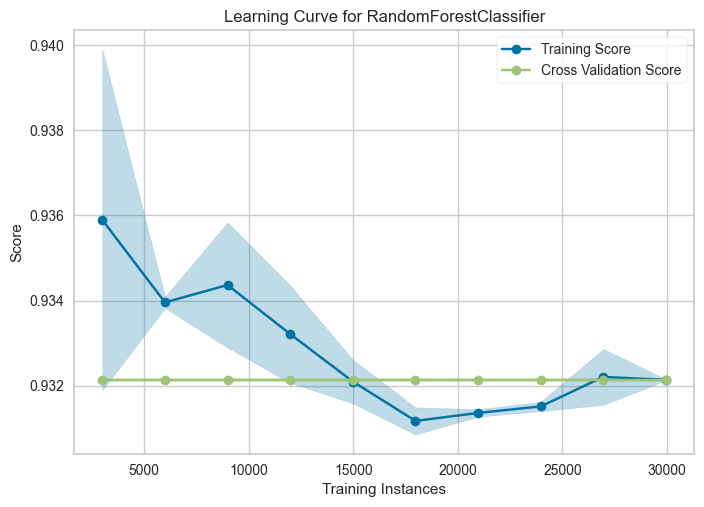

In [139]:
metric = make_scorer(accuracy_score, response_method="predict")
visualizer = LearningCurve(
    RandomForestClassifier(**params), scoring=metric, cv=StratifiedKFold(), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_test, y_test).show()

## Настройка гиперпараметров AdaBoostingClassifier

In [243]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [144]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [242]:
import optuna

def objective(trial):
    # Гиперпараметры слабой модели (DecisionTreeClassifier)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Гиперпараметры AdaBoost
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1.0, log=True)
    algorithm = trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm=algorithm,
        random_state=42
    )

    # Кросс-валидация
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X, y, cv=cv, scoring="precision", n_jobs=-1).mean()
    return score

# Создаём и запускаем исследование
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Результаты
print("Лучшие параметры:")
print(study.best_params)
print(f"Лучшая точность (accuracy): {study.best_value:.4f}")

[I 2025-04-11 10:25:44,283] A new study created in memory with name: no-name-9095e33c-d42a-4259-b53f-6ad0443a724b
[I 2025-04-11 10:27:43,831] Trial 0 finished with value: 0.49246061860411633 and parameters: {'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 10, 'n_estimators': 151, 'learning_rate': 0.0010780577258734415, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.49246061860411633.
[I 2025-04-11 10:28:40,594] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 4, 'n_estimators': 173, 'learning_rate': 0.0013967802877864167, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.49246061860411633.
[I 2025-04-11 10:31:30,019] Trial 2 finished with value: 0.46190826181417055 and parameters: {'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 2, 'n_estimators': 209, 'learning_rate': 0.10225529213208291, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.49246061860411633.
[I 2025-04-11 10:32:34,775] Tr

Лучшие параметры:
{'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 8, 'n_estimators': 142, 'learning_rate': 0.004027099219004521, 'algorithm': 'SAMME.R'}
Лучшая точность (accuracy): 0.5637


In [244]:
study.best_params

{'max_depth': 4,
 'min_samples_split': 12,
 'min_samples_leaf': 8,
 'n_estimators': 142,
 'learning_rate': 0.004027099219004521,
 'algorithm': 'SAMME.R'}

### Посмотрим на результат

In [246]:
%time
model_Ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                                                                min_samples_split=study.best_params["min_samples_split"],
                                                                min_samples_leaf=study.best_params["min_samples_leaf"]),
                                                                n_estimators=study.best_params["n_estimators"],
                                                                learning_rate=study.best_params["learning_rate"],
                                                                algorithm=study.best_params["algorithm"]).fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [247]:
print("Scores:")
get_scores(model_Ada, X_test, y_test)
print("Cross Validation Scores:")
get_cross_val_scores(model_Ada, X, y)

Scores:
accuracy_score: 0.9325374569345405
precision_score: 0.5824175824175825
recall_score: 0.02085792994883904
f1_score: 0.04027355623100304
Cross Validation Scores:
accuracy_score: 0.9333983232087008
precision_score: 0.5467487410748241
recall_score: 0.02057942057942058
f1_score: 0.5025824201612157


### Анализ модели

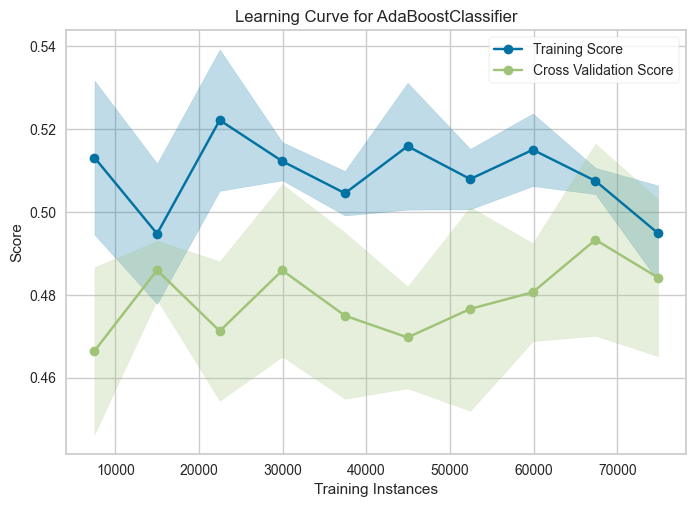

In [248]:
metric = make_scorer(precision_score, response_method="predict")
visualizer = LearningCurve(
    AdaBoostClassifier(), scoring=metric, cv=StratifiedKFold(n_splits=3), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_train, y_train).show()

## Kaggle

In [32]:
# Функция для отправки результатов работы модели на Kaggle
def try_kaggle(model, X):
    probs = model.predict_proba(X)
    ans = []
    for prob in probs:
        ans.append(prob[1])

    out_pd = pd.DataFrame({
        "Id": [i for i in range(1, len(ans) + 1)],
        "Probability": ans
    })
    out_pd.to_csv("out.csv", index=False)

In [33]:
data_test = pd.read_csv("data/cs-test.csv", delimiter=',', index_col=0)
X_test_test = data_test[data_test.columns[1:]].interpolate()
scaled_X_test_test = scaler.fit_transform(X_test_test)
try_kaggle(model_GB, scaled_X_test_test)